


# Population Analysis using US Census Data

I have used data containing attrbutes such as Race, Gender, labour, polulation etc and used unsupervised techniques and models to find special paradigms. In order to help with the data processing I have used AWS sagemaker tools to simplify the process and especially to help with compuational power.
More spciefically, 1) I have preprocessed using pandas, scikit-lean etc 
                   2) Used PCA to reduce unwanted data attributes
                   3) K- means clustering to uncover speciall patterns


I used  US Census data (https://en.wikipedia.org/wiki/United_States_Census).



---

In [ ]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [ ]:
# sagemaker libraries
import boto3
import sagemaker

Uploading the data to AWS server bucket for processing.

In [ ]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
# S3 bucket name
bucket_name='aws-ml-blog-sagemaker-census-segmentation'

In [ ]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['Census_Data_for_SageMaker.csv']


In [ ]:
file_name=files[0]

print(file_name)

Census_Data_for_SageMaker.csv


Data gathering from S3.

In [ ]:
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

# what info does the object contain?
display(data_object)

{'ResponseMetadata': {'RequestId': 'BDF2626E80A9D106',
  'HostId': 'rJGVoQcGEgWO1A0qgYIhadqWBWjAf/9FHxuai6IObBFm++9aC+sbKm/FqeQhJs2X8XRb+f2aYvc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'rJGVoQcGEgWO1A0qgYIhadqWBWjAf/9FHxuai6IObBFm++9aC+sbKm/FqeQhJs2X8XRb+f2aYvc=',
   'x-amz-request-id': 'BDF2626E80A9D106',
   'date': 'Fri, 08 Mar 2019 00:07:34 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7fc8c171fc18>}

In [ ]:
# information is in the "Body" of the object
data_body = data_object["Body"].read()
print('Data type: ', type(data_body))

Data type:  <class 'bytes'>


In [ ]:
# read in bytes data
data_stream = io.BytesIO(data_body)

# create a dataframe
counties_df = pd.read_csv(data_stream, header=0, delimiter=",") 
counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [ ]:
# print out stats about data
# rows = data, cols = features
print('(orig) rows, cols: ', counties_df.shape)

# drop any incomplete data
clean_counties_df = counties_df.dropna(axis=0)
print('(clean) rows, cols: ', clean_counties_df.shape)

(orig) rows, cols:  (3220, 37)
(clean) rows, cols:  (3218, 37)


In [ ]:
# index data by 'State-County'
clean_counties_df.index=clean_counties_df['State'] + "-" + clean_counties_df['County']
clean_counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [ ]:
# drop the old State and County columns, and the CensusId column
# clean df should be modified or created anew
drop=["CensusId" , "State" , "County"]
clean_counties_df = clean_counties_df.drop(columns=drop)
clean_counties_df.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


Now, what features do you have to work with?

In [ ]:
# features
features_list = clean_counties_df.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


In [ ]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::467380521728:role/service-role/AmazonSageMaker-ExecutionRole-20190307T133365


In [ ]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-west-1-467380521728



Creating PCA Model


In [ ]:
# define location to store model artifacts
prefix = 'counties'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-west-1-467380521728/counties/


In [ ]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=33

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


In [ ]:
# convert df to np array
train_data_np = counties_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

## Training the model

In [ ]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

INFO:sagemaker:Creating training-job with name: pca-2019-03-08-00-07-38-756


2019-03-08 00:07:38 Starting - Starting the training job...
2019-03-08 00:07:41 Starting - Launching requested ML instances......
2019-03-08 00:08:42 Starting - Preparing the instances for training......
2019-03-08 00:10:05 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[03/08/2019 00:10:18 INFO 140212411717440] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[03/08/2019 00:10:18 INFO 140212411717440] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_components': u'33'}
[03/08/2019 00:10:18 INFO 140212411717440] Final configuration: {u'num_components': u'33', u'_num_gpus

## Model and data Unzipping

In [ ]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2019-03-07-22-53-18-299'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

counties/pca-2019-03-07-22-53-18-299/output/model.tar.gz


2304

In [ ]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>, 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1.59879066e-02  5.04589686e-03]
 [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
   1.57304872e-02  4.95312130e-03]
 [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
   1.62378680e-02  5.13597298e-03]
 ...
 [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
  -3.09406728e-01 -6.34506866e-02]
 [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 ...  4.17341813e-02


In [ ]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

**Note**: The _top_ principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.

In [ ]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

            0
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180


### Calculating variance



In [ ]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]


In [ ]:
# test cell
n_top_components = 7 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.80167246


In [ ]:
# features
features_list = counties_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## Uncovering Model attributes.

In [ ]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


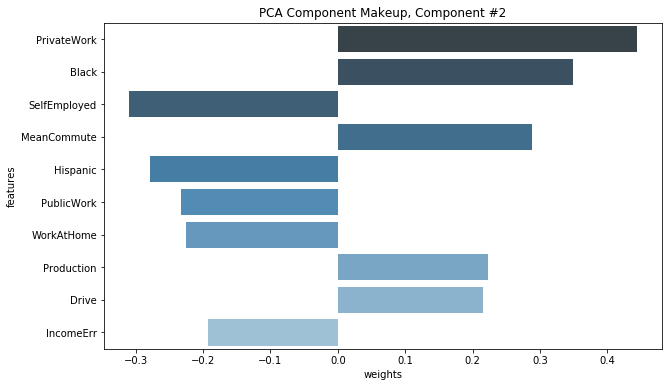

In [ ]:
# display makeup of first component
num=2
display_component(v, counties_scaled.columns.values, component_num=num, n_weights=10)

# Running PCA

In [ ]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: pca-2019-03-08-00-12-08-382
INFO:sagemaker:Creating endpoint with name pca-2019-03-08-00-07-38-756


--------------------------------------------------------------------------!CPU times: user 362 ms, sys: 36.5 ms, total: 398 ms
Wall time: 6min 15s


We can pass the original, numpy dataset to the model and transform the data using the model we created. Then we can take the largest n components to reduce the dimensionality of our data.

In [ ]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [ ]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.0002009272575378418
      values: 0.0002455431967973709
      values: -0.0005782842636108398
      values: -0.0007815659046173096
      values: -0.00041911262087523937
      values: -0.0005133943632245064
      values: -0.0011316537857055664
      values: 0.0017268601804971695
      values: -0.005361668765544891
      values: -0.009066537022590637
      values: -0.008141040802001953
      values: -0.004735097289085388
      values: -0.00716288760304451
      values: 0.0003725700080394745
      values: -0.01208949089050293
      values: 0.02134685218334198
      values: 0.0009293854236602783
      values: 0.002417147159576416
      values: -0.0034637749195098877
      values: 0.01794189214706421
      values: -0.01639425754547119
      values: 0.06260128319263458
      values: 0.06637358665466309
      values: 0.002479255199432373
      values: 0.10011336207389832
      values: -0.1136140376329422
      values: 0

In [ ]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    counties_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        counties_transformed=counties_transformed.append([list(components)])

    # index by county, just like counties_scaled
    counties_transformed.index=counties_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    counties_transformed = counties_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return counties_transformed.iloc[:, ::-1]
    

In [ ]:
# specify top n
top_n = 7

# call your function and create a new dataframe
counties_transformed = create_transformed_df(train_pca, counties_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7']
counties_transformed.columns=PCA_list 

# print result
counties_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


### Deleting Enpoint

In [ ]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: pca-2019-03-08-00-07-38-756


In [ ]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 8

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)


In [ ]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = counties_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [ ]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data)

INFO:sagemaker:Creating training-job with name: kmeans-2019-03-08-00-37-22-788


2019-03-08 00:37:22 Starting - Starting the training job...
2019-03-08 00:37:27 Starting - Launching requested ML instances......
2019-03-08 00:38:31 Starting - Preparing the instances for training......
2019-03-08 00:39:53 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[03/08/2019 00:40:07 INFO 140021904598848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'

### Deploying K- means model


In [ ]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: kmeans-2019-03-08-00-40-34-502
INFO:sagemaker:Creating endpoint with name kmeans-2019-03-08-00-37-22-788


---------------------------------------------------------------------------------------!CPU times: user 436 ms, sys: 35.3 ms, total: 472 ms
Wall time: 7min 20s


### Adding labels to model

In [ ]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

In [ ]:
# print cluster info for first data point
data_idx = 0

print('County is: ', counties_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

County is:  Alabama-Autauga

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 3.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.27046188712120056
    }
  }
}



### Data Visualization

In [ ]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [ ]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

1.0    994
5.0    595
3.0    449
0.0    390
6.0    339
4.0    218
7.0    141
2.0     92
Name: 0, dtype: int64


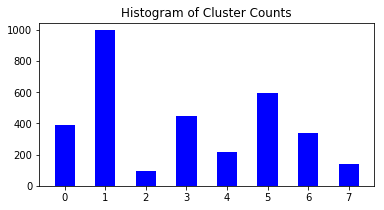

In [ ]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

Now, you may be wondering, what do each of these clusters tell us about these data points? To improve explainability, we need to access the underlying model to get the cluster centers. These centers will help describe which features characterize each cluster.

### Endpoint Removal 

In [ ]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: kmeans-2019-03-08-00-37-22-788


In [ ]:
# download and unzip the kmeans model file
kmeans_job_name = 'kmeans-2019-03-08-00-37-22-788'

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')


2304

In [ ]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[ 3.68001163e-01  2.26354256e-01  7.88291916e-02  2.61262119e-01
   9.61402357e-02 -5.05092032e-02  3.57557014e-02]
 [-7.32245147e-02  1.05659112e-01  1.13722928e-01 -6.33113831e-02
  -3.95483039e-02  4.66217995e-02 -2.19286084e-02]
 [ 1.31537044e+00 -2.57377833e-01 -1.57875896e-01 -4.15273398e-01
  -1.25370100e-01  1.16665870e-01  1.62481740e-01]
 [-1.62926733e-01  4.53134663e-02 -3.00800741e-01  7.25739002e-02
  -4.14044000e-02  5.90644330e-02  8.24726187e-04]
 [ 3.09595257e-01 -1.57976970e-01 -1.62361398e-01 -1.85713798e-01
   1.38460830e-01 -1.14379212e-01 -6.49842843e-02]
 [-2.69347250e-01  8.37490428e-03 -1.81501284e-02 -7.30615258e-02
   4.57714126e-03 -8.09832960e-02 -1.25052175e-02]
 [-2.39941925e-01 -3.17158133e-01  1.06285624e-01  4.89501953e-02
   4.87177409e-02 -6.73310785e-03  1.10704802e-01]
 [ 2.05574751e-01 -4.47796524e-01  8.54142755e-02  1.98281378e-01
  -1.12922713e-01 -1.60498768e-02 -1.51252389e-01]]
<NDArray 8x7 @cpu(0)>]


In [ ]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=counties_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
0,0.368001,0.226354,0.078829,0.261262,0.096140,-0.050509,0.035756
1,-0.073225,0.105659,0.113723,-0.063311,-0.039548,0.046622,-0.021929
2,1.315370,-0.257378,-0.157876,-0.415273,-0.125370,0.116666,0.162482
3,-0.162927,0.045313,-0.300801,0.072574,-0.041404,0.059064,0.000825
4,0.309595,-0.157977,-0.162361,-0.185714,0.138461,-0.114379,-0.064984
5,-0.269347,0.008375,-0.018150,-0.073062,0.004577,-0.080983,-0.012505
6,-0.239942,-0.317158,0.106286,0.048950,0.048718,-0.006733,0.110705
7,0.205575,-0.447797,0.085414,0.198281,-0.112923,-0.016050,-0.151252


### DATA VISUALIZATION - Using heatmat to plot centroids

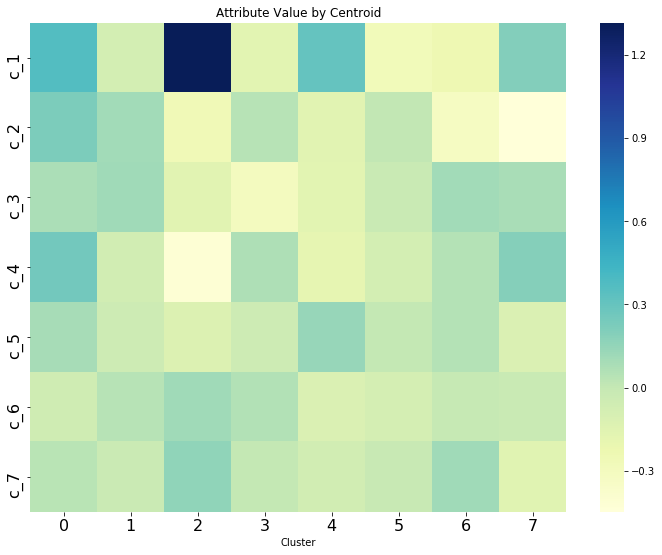

In [ ]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

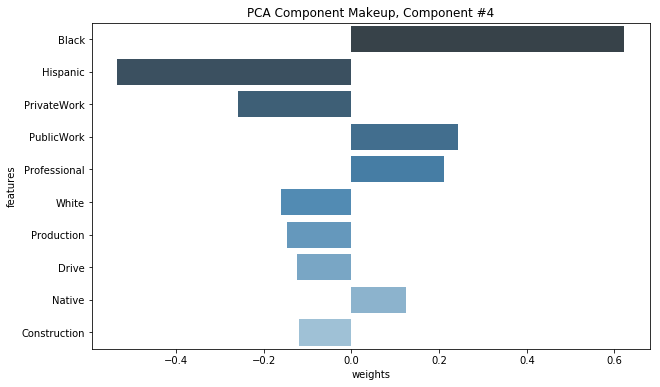

In [ ]:
# what do each of these components mean again?
# let's use the display function, from above
component_num=4
display_component(v, counties_scaled.columns.values, component_num=component_num)

### Observing Patterns

Here I clustered labels back to each individual county to examined which counties are naturally grouped together.

In [ ]:
# add a 'labels' column to the dataframe
counties_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_counties = counties_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_counties.head(20)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,labels
Georgia-Candler,0.363197,0.109423,0.204951,0.059516,0.067597,-0.019374,0.030013,0
Louisiana-Concordia,0.409779,0.204391,0.191335,0.268234,0.007950,-0.054527,0.181117,0
Virginia-Newport News city,0.261421,0.177800,-0.229566,0.321782,0.014855,-0.102143,-0.024013,0
Louisiana-De Soto,0.295931,0.348835,0.048717,0.164811,0.166941,0.010911,0.040519,0
Florida-Gadsden,0.662961,0.165212,0.012804,0.476595,0.042991,0.093047,0.007101,0
Virginia-Norfolk city,0.345661,0.123631,-0.143410,0.363603,-0.007470,-0.083678,-0.005115,0
Louisiana-East Baton Rouge,0.242962,0.229884,-0.259422,0.379246,0.018616,-0.107516,0.071976,0
Virginia-Petersburg city,0.792302,0.426670,-0.051610,0.611594,0.033392,-0.232590,0.001919,0
Louisiana-East Carroll,0.933136,0.293730,0.356297,0.540606,-0.054206,-0.278123,0.160721,0
Louisiana-East Feliciana,0.286842,0.201158,0.002600,0.365350,0.140875,0.131723,0.048354,0
